<a href="https://colab.research.google.com/github/KaroAntonio/climate-social-analysis/blob/main/notebooks/Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Data Wrangling

Here we import our datasets, explore the features we have to work with, get a feel for the distributions, and do some initial cleaning.

We want to keep in mind that we have the following goals for this analysis:
- Extract Topics from the Tweet Data (Unsupervised)
- Label Emotions for each tweet (Possibly supervised)
- Establish Association between Topics and Emotions

Our Datasets:
- Climate Tweets (15m)

These tweets have already been filtered from the broader twitter stream, so this dataset includes only tweets which include either 'climate change' or 'global warming'

Data Wrangling Steps Taken:

1. Load Dataset
2. Explore raw Dataset characteristics
3. Text Preprocessing
4. Tokenization
5. Token Preprocessing




In [4]:
!pip install emoji

In [125]:
!pip install joblib

In [137]:
from google.colab import drive
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import words
from itertools import chain
import pandas as pd
import numpy as np
import re
import emoji

In [135]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
DRIVE_DIR = "/content/drive/MyDrive/Climate Social Analysis/data/"
TWEET_TEXT_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-tweet-data.csv"
TWEET_TIMESTAMPS_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-timestamps.csv"
PREPROCESSED_TEXT_PATH = f"{DRIVE_DIR}preprocessed_text.csv"

In [9]:
# Load tweets
text_df = pd.read_csv(TWEET_TEXT_DATA_PATH)

In [10]:
# Load Timestamp Metadata
timestamps_df = pd.read_csv(TWEET_TIMESTAMPS_DATA_PATH)

In [11]:
# What is the shape of our data?
text_df.shape

(15789411, 2)

In [12]:
# What are our cols?
text_df.columns

Index(['id', 'text'], dtype='object')

In [13]:
# Is there an 'id' for each row?
text_df['id'].nunique() == text_df.shape[0]

True

In [14]:
# Ok let's use 'id' for the index
text_df.set_index('id', inplace=True)

In [15]:
# What do our tweets look like?
pd.set_option('display.max_colwidth', 300)
text_df.sample(10)

,text
id,
1047676175055638528,How do we convince the United States as a major contributor to climate change and as a land that absorbs impacts concentrated on its coasts that an investment in our climate future will save us resources in dealing with the affects of the cycle we are contributing to?
874004596330348544,.@nplhpodcast I think we just found our new favorite podcast! #climatechange https://t.co/62hPTzAgPb
737657666500218880,Diving sites in Thailand closed due to coral bleaching https://t.co/NB67fu1Woi via @TravelPulse #climatechange https://t.co/EZRnoHWn3G
987320963271397377,"RT @SkypeClassroom: #EarthDay is right around the corner! Inspire your students by inviting an expert in conservation, climate change and e…"
1119314615744253953,@EEmechete @UNMGCY @UNDPNigeria @FMEclimate @SustyVibes @fmeclimateng @UNDPClimate @ClimateWed @FMEnvng @ClimateReality @UNFCCC Electric Cars are designed to eradicate global warming.The emission of carbon monoxide from cars will gradually be eliminated and thereby creating a healthy environment...
1040558685024669697,RT @MisterRudeman: Show more videos of the weather disrespecting the flag so the conservatives will want to fight climate change too https:…
932620567550857216,Short answers to hard questions about climate change: https://t.co/fDp8vtCBwy
1067585835900551169,"@4YrsToday @MasonPampinella 34% said yes it’s a hoax. I’d bet most of them are trump supporters. The only hoax concerning climate change is trump’s denial of it. Oh, &amp; his regime as a whole. This is not just dangerous for the present, but for the future of our families on earth. Really SMH h..."
612189596680634368,"And see his views http://t.co/yFe2N9ucmA - anti abortion rights &amp; equal marriage, dabbles in climate change denial.\n https://t.co/Xy6txJ8oCm"


In [16]:
# Ok how many duplicates do we have?
n_duplicates = text_df.duplicated().sum()
print(f"{n_duplicates} total duplicates")
print(f"{n_duplicates / text_df.shape[0] * 100}% duplicates")

6385951 total duplicates
40.444516898065416% duplicates


In [17]:
no_dupes_df = text_df.drop_duplicates()

In [18]:
# Do we have null values?
no_dupes_df.isnull().sum()

text    0
dtype: int64

<ipython-input-19-777e7e0b9bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dupes_df['text_length'] = no_dupes_df['text'].str.len()


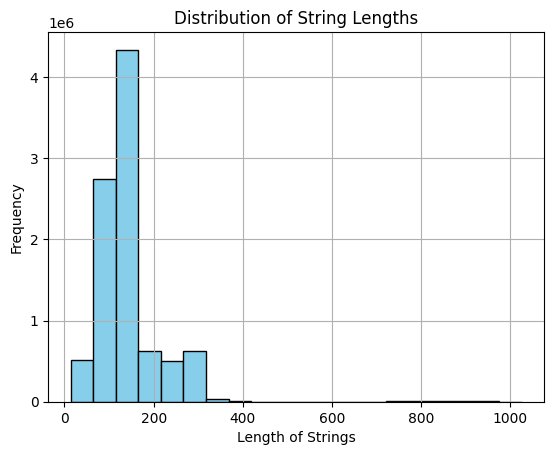

In [19]:
# What is the distribution of the length of the tweets?
# Calculate the length of each string in the 'text' column
no_dupes_df['text_length'] = no_dupes_df['text'].str.len()

# Plot the distribution of string lengths
plt.hist(no_dupes_df['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of String Lengths')
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This distribution makes sense since the original length of tweets was 140chars and then got increased to 280chars. So we see a big spike at 140 and then a tail up to 280.

In [20]:
# Merge in Timestamp Data
timestamps_df.set_index('id', inplace=True)

In [21]:
merged_df = no_dupes_df.merge(timestamps_df, left_index=True, right_index=True)

In [22]:
# What do the timestamps look like?
n_null_timestamps = merged_df['created_at'].isnull().sum()
print(f'N Null timestamps: {n_null_timestamps}')
print('Example Timestamp: ',merged_df.iloc[0]['created_at'])
print(merged_df['created_at'])

N Null timestamps: 0
Example Timestamp:  2006-06-06 16:06:42+00:00
id
6132                   2006-06-06 16:06:42+00:00
13275                  2006-07-23 21:52:30+00:00
23160                  2006-08-29 01:52:30+00:00
57868                  2006-11-07 02:46:52+00:00
304553                 2006-11-27 14:27:43+00:00
                                 ...            
1178906786792972288    2019-10-01 05:37:35+00:00
1178908472919769088    2019-10-01 05:44:17+00:00
1178908993022042112    2019-10-01 05:46:21+00:00
1178909001414610944    2019-10-01 05:46:23+00:00
1178910020626464768    2019-10-01 05:50:26+00:00
Name: created_at, Length: 9403460, dtype: object


In [23]:
# Convert 'created_at' into timestamp
merged_df['timestamp'] = pd.to_datetime(merged_df['created_at'])

In [24]:
# Group by year and count the number of rows per year
rows_per_year = merged_df.groupby(merged_df['timestamp'].dt.year).size()
print(rows_per_year)

timestamp
2006         12
2007       3597
2008      28946
2009     448153
2010     409508
2011     294049
2012     186319
2013     268237
2014     371940
2015    1206970
2016    1142734
2017    1488244
2018    2717974
2019     836777
dtype: int64


In [25]:
# Looks like the timestamps are working, so let's drop the 'created_at' str
merged_df.drop('created_at', axis=1, inplace=True)

## NLP Cleaning

At this point, having done the basic data cleanup, there is a lot of more nuanced language processing that can be done. Since we're going to be doing Topic analysis and Emotion Labelling, we can assume we're going to want to clean up the text and possibly already tokenize our strings.

### 1. Text Preprocessing

Our goal is to make the text as regular as possible and the token count (dictionary) should be as small as possible.
Some [basic text preprocessing](https://medium.com/@farhahahahahan/03-basic-text-preprocessing-nlp-90ea4469fb87) steps are:
- lowercasing
- remove html
- remove urls
- remove punctuation
- remove users
- remove hashtags (but we want to retain the actual hashtag text)
- remove emails
- remove low info chars

Some further token-based treatment that might be better done in EDA are:
- tokenization
- stopword removal
- spelling correction
- chatword translation
- handling emoji
- filtering for language (english)
- lemmatization / stemming


In [26]:
# Preprocess tweet text

def lower(text):
  return text.lower()

def remove_urls(text):
  # remove anything with a domain extension like ending
  text = re.sub(r'https?://\S+|http?://\S+', ' ', text)
  text = re.sub(r'\b\w+\.\w+\b',' ',text)
  text = re.sub(r'www\.[^\s]+', ' ', text)
  # remove words containing '://'
  text = re.sub(r'\b\S*:\/\/\S*\b', ' ', text)
  return text

def remove_html_tags(text):
  return re.sub('<.*?>', ' ', text)

def remove_user_mentions(text):
  return re.sub(r'@\w+', ' ', text)

def remove_email_addresses(text):
  return re.sub(r'\S+@\S+', ' ', text)

def remove_escape_sequences(text):
  return re.sub(r'[\r\n]+', ' ', text)

def translate_emoji(text):
  # translate emoji to text
  return emoji.demojize(text)

def remove_contraction(text):
  return re.sub(r'(?<=[a-zA-Z])\'(?=[a-zA-Z])', '', text)

def remove_low_info_chars(text):
  # remove chars that do not retain much 'meaning'
  # in this case we retain only a-z, 0-9, '!', and '?'
  return re.sub(r'[^0-9a-z\s!?]', ' ', text)

def preprocess(text):
  text = lower(text)
  text = remove_urls(text)
  text = remove_html_tags(text)
  text = remove_user_mentions(text)
  text = translate_emoji(text)
  text = remove_contraction(text)
  text = remove_escape_sequences(text)
  text = remove_low_info_chars(text)
  return text

def applyPreprocessing(sr):
  return sr.apply(preprocess)

In [27]:
# Let's test the preprocessing on a small sample
test = applyPreprocessing(merged_df['text'].sample(10000))

In [28]:
# Let's test to see if the output looks nice
# There are a lot of spaces and some of the tokens are a bit strange ie 80sf, but these are cases that can be handled on a token basis
for i, doc in enumerate(test.values[120:130]):
  print(i,doc)

0       if so  then global warming  amp  natures destruction must be illegitimate unwanted produces
1 removing  co2 from atmosphere won t save us  we have to cut emissions now       climatechange  carbon
2 has global warming become our new future time horizon   beyond which we cannot think  act  and imagine?
3 rt sciencenews  rt snstudents  as their homelands experience uncomfortable changes  many people adapt by migrating elsewhere  they are the first  climatechange refugees  the first feature in our series  the climate change chronicles      
4   a similar process has already happened in his cabinet  with epa appointees being mostly climate change deniers and big oil shills 
5 interesting insights  how americans think about  climatechange  in six  maps  
6 oggi su    laddio al fossile dell  irlanda    il primo paese al mondo a bloccare gli investimenti    fossilfuel  divestment  finanzasostenibile  climatechange  parisagreement          
7  wednesdaywisdom    education on  climatecha

In [29]:
# There's a strange string 'lqiq3jwcut' that might be a part of a url or something, let's investigate
# It looks like strings starting with "://" should be treated as urls also
merged_df.loc[770113887576395776]

text           American pika vanishing from western US as 'habitat lost to climate change' https://t.co/CxUZFWhQhb ://t.co/LQIq3jwcUt RT @ClimateNexus
text_length                                                                                                                                        135
timestamp                                                                                                                    2016-08-29 04:20:33+00:00
Name: 770113887576395776, dtype: object

In [30]:
# How long would it take to run the preprocessing on all ~10m tweets?
# A: Running on 100k tweets is 19s, so 10m would be 100x that... a bit long
test = applyPreprocessing(merged_df['text'].sample(100000))

In [31]:
# We only have 2 cores, we're going to need a better runtime
# Ah, the GPU100 env has 8-12 cores, much better!

In [32]:
# Both of these took around 20s to run, something is not right with the parallelization
# How many cores do we have?
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores available:", num_cores)

Number of CPU cores available: 8


In [33]:
# Apply the function to each row of the DataFrame in parallel
# Runtime here is 4mins for the ~10m rows

# Define a function to apply preprocessing to each element of the Series in parallel
def apply_preprocessing_parallel(sr):
    n_jobs = -1 # use all cores
    return Parallel(n_jobs=n_jobs)(delayed(preprocess)(text) for text in sr)

preprocessed_texts = apply_preprocessing_parallel(merged_df['text'])

In [34]:
merged_df['preprocessed'] = preprocessed_texts

In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9403460 entries, 6132 to 1178910020626464768
Data columns (total 4 columns):
 #   Column        Dtype              
---  ------        -----              
 0   text          object             
 1   text_length   int64              
 2   timestamp     datetime64[ns, UTC]
 3   preprocessed  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 616.7+ MB


In [36]:
merged_df.drop(columns=['text_length'], inplace=True)

In [140]:
# Tokenization
# Now that we've preprocessed out text, we want to tokenize it and explore what our token-space looks like
# We use a set for tokens as we treat our tokens as a bag-of-words

def handle_punctuation(text):
  # We want to buffer '!' and '?' with whitespace to treat them as tokens
  return text.replace('!', ' ! ').replace('?', ' ? ')

def tokenize(text):
  # We use the most basic tokenization approach, splitting by whitespace
  # this is reasonable since we've preprocessed all the punctuation and formatting
  return {token.strip() for token in text.split()}

def applyTokenization(sr):
  return sr.apply(handle_punctuation).apply(tokenize)

In [141]:
# Apply Tokenization
# runtime(100k)=1.23s so we would expect runtime(10m)=123s
%%time
tokens_sr = applyTokenization(merged_df['preprocessed'])
print(f'Tokenized {len(tokens_sr)} rows')

Tokenized 9403460 rows
CPU times: user 1min 30s, sys: 10.9 s, total: 1min 41s
Wall time: 1min 41s


In [39]:
# Check to make sure Tokenization went as expected
# The tokens look well formed, but there are definitely tokens that we want to clean
pd.set_option('display.max_colwidth', None)
tokens_sr.sample(10)

id
1123419606557822976                                                             [since, the, trump, administration, doesnt, care, about, the, environment, ignoring, global, warming, or, poor, and, starving, asylum, seekers, the, states, might, as, well, dump, tons, of, unessasary, bug, spray, to, make, things, go, away]
1128305249888931840                                                                                                                                                                                                                                                    [climate, inaction, is, expensive, climatechange, cdnpoli]
1123254690924433412                                                                                                                                                                                                         [in, a, switch, some, republicans, start, citing, climate, change, as, driving, their, policies, via]
1015316282089115650            

In [40]:
# What is the distribution of our tokens?

tokens_list = tokens_sr.tolist()
all_tokens_list = [token for tokens in tokens_list for token in tokens]
freq_dist = FreqDist(all_tokens_list)

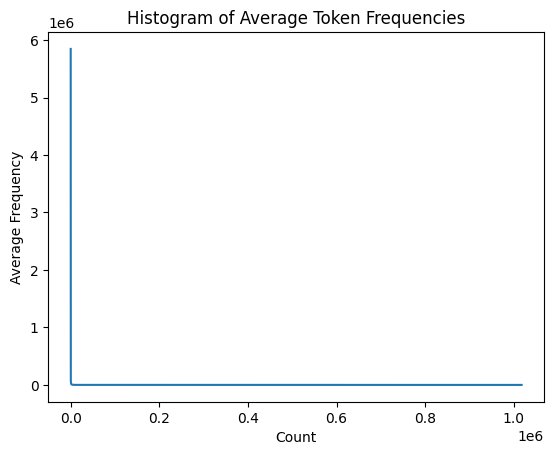

In [70]:
# Plot the distribution of token frequencies
token_freqs = sorted(list(freq_dist.values()), reverse=True)
x = np.arange(0, len(token_freqs), 1)

# Plot Frequency line
plt.plot(x, token_freqs)
plt.ylabel('Average Frequency')
plt.xlabel('Token Rank')
plt.title('Histogram of Average Token Frequencies')
plt.show()

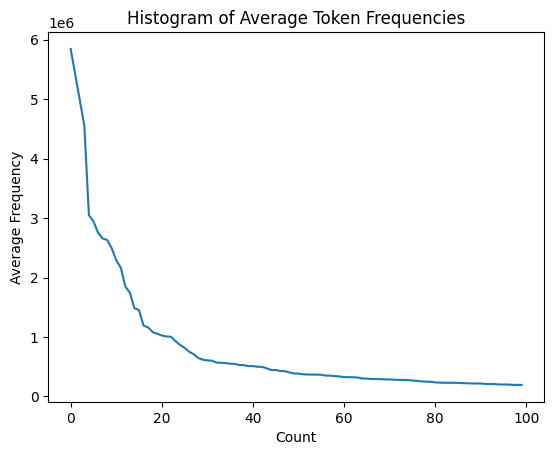

In [72]:
# Plot the Distribution of the top N most relevant tokens
# There's a huge right tail on the dist of tokens, with most being present only very few times and a very low % being... very present
# so let's plot only the top N

top_n = 100

token_freqs = sorted(list(freq_dist.values()), reverse=True)[:top_n]
x = np.arange(0, len(token_freqs), 1)

# Plot Frequency line
plt.plot(x, token_freqs)
plt.ylabel('Token Frequency')
plt.xlabel('Token Rank')
plt.title('Histogram of Average Token Frequencies')
plt.show()

In [111]:
# Some Token Distribution stats
print(f'There are {len(freq_dist)} unique tokens')
print(f'There are {len(all_tokens_list)} total tokens')
print(f'The ratio of unique to total tokens is: {len(freq_dist) / len(all_tokens_list)}')
print(f'Representative i-th freqs:')
token_freqs = sorted(list(freq_dist.values()), reverse=True)
for i in range(0,10000,1000):
  print(f'{i}th: {token_freqs[i]}')
for i in range(10000,100000,10000):
  print(f'{i}th: {token_freqs[i]}')
print(f"{token_freqs.index(3)}th: Index of first freq of 3")
print(f"{token_freqs.index(2)}th: Index of first freq of 2")
print(f"{token_freqs.index(1)}th: Index of first freq of 1")

There are 1017623 unique tokens
There are 174720879 total tokens
The ratio of unique to total tokens is: 0.005824278161970556
Representative i-th freqs:
0th: 5845661
1000th: 19937
2000th: 8828
3000th: 5146
4000th: 3452
5000th: 2514
6000th: 1924
7000th: 1509
8000th: 1231
9000th: 1015
10000th: 856
20000th: 251
30000th: 119
40000th: 71
50000th: 47
60000th: 34
70000th: 26
80000th: 20
90000th: 17
234315th: Index of first freq of 3
294818th: Index of first freq of 2
435180th: Index of first freq of 1


In [153]:
# Based on the above, the top 2000 tokens seem to be the most significant.
# What are our top Freqs?
freq_dist.most_common(40)

[('the', 5845661),
 ('climate', 5411593),
 ('change', 4985521),
 ('to', 4548087),
 ('of', 3048368),
 ('global', 2945563),
 ('warming', 2754633),
 ('is', 2657120),
 ('and', 2632749),
 ('a', 2494207),
 ('in', 2293312),
 ('climatechange', 2162815),
 ('on', 1848936),
 ('?', 1743297),
 ('!', 1484590),
 ('for', 1452439),
 ('that', 1190401),
 ('it', 1161819),
 ('rt', 1080641),
 ('you', 1054137),
 ('i', 1025514),
 ('we', 1008479),
 ('are', 1004609),
 ('about', 931146),
 ('this', 866523),
 ('with', 817115),
 ('be', 753773),
 ('not', 709160),
 ('by', 645383),
 ('from', 618465),
 ('as', 606378),
 ('will', 600807),
 ('amp', 568419),
 ('s', 566545),
 ('its', 561132),
 ('have', 550840),
 ('how', 547199),
 ('more', 528736),
 ('but', 526531),
 ('what', 510652)]

In [77]:
# It looks like some tokens are single letters - which are they?
for i in range(ord('a'), ord('z') + 1):
  print(chr(i), freq_dist[chr(i)])

a 2494207
b 33671
c 55864
d 49043
e 33366
f 23767
g 12901
h 14803
i 1025514
j 6039
k 7946
l 14722
m 58469
n 36692
o 37965
p 23084
q 10838
r 42232
s 566545
t 293507
u 69083
v 20413
w 63288
x 8938
y 22943
z 2275


In [154]:
# Let's explore what the tweets look like for some of these
# Let's roughly assume that tokens need to have a freq > 10000 to be 'relevant'
merged_df['tokens'] = tokens_sr

def get_examples_given_token(df, token):
  df_subset = df[df['tokens'].apply(lambda tokens: token in tokens)]['text']
  return(df_subset)

get_examples_given_token(merged_df, 's').sample(10)

id
615533536469250048                                                                                               It’s in the ORANGE BOX! See more UNDERWATER than ever before http://t.co/Bqer0mUgtt Plug -N-Play #climatechange http://t.co/CuaMV0g80L
1122965244588900352                                                                                                                                        @_apdabdoub It’s so sad 😔 poor earth. if only someone important believed in global warming 🙄
1073883893554507776                        Every five weeks, Chinese cities add 9,500 of the zero-emissions busses—the equivalent of London’s entire working fleet.\n#climate #ClimateBreakdown #climatechange #ClimateAction \nhttps://t.co/XjEIYHGi2v
938853977181048833     Ted Cruz later on in the News today*\n\nCruz: It’s snowin’ in South Texas and the liberals STILL want you to think the earth is warming and climate change is real? Those looney liberals and their science. \n\nCalling it now.
16579

In [172]:
# Process Tokens
# Now that we have tokens, we want to clean out some of the tokens that are 'clearly' non-informative
# There are several classes of tokens that

# Here we want to:
# 1. Remove common and 'meaningless' tokens ie stop-words
# 2. Translate some compound tokens

CUSTOM_STOPWORDS = [
    'rt', # retweet
    'amp', # from html for and
    's', # this seems to be mostly from 's contractions
]

translation_map = {
    'climatechange':{'climate','change'},
    'globalwarming':{'global','warming'},
    'actonclimate':{'act','on','climate'},
}

def remove_stopwords(tokens):
  return [token for token in tokens if token not in CUSTOM_STOPWORDS]

def translate_compound_tokens(tokens):
  new_tokens = set()
  for t in tokens:
    if t in translation_map:
      new_tokens.update(translation_map[t])
    else:
      new_tokens.add(t)
  return new_tokens

def processTokens(tokens):
  tokens = remove_stopwords(tokens)
  tokens = translate_compound_tokens(tokens)
  return tokens

def applyProcessTokens(sr):
  return sr.apply(processTokens)

In [ ]:
# Dummy data with sets
processed_tokens_sr = applyProcessTokens(tokens_sr)

In [44]:
# Save preprocessed DF
merged_df.to_csv(PREPROCESSED_TEXT_PATH, index=True)